In [1]:
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
import glob
import os
import MDAnalysis as mda
from scipy.stats import *
from scipy.stats import entropy
from numpy.linalg import norm
import numpy as np
from peakdetect import peakdetect
import scipy.integrate as integrate

import scipy.special as special

# Kullback–Leibler divergence

### Introduction
<br>
Consider two probability distributions P and Q. Usually,P represents the data, the observations, or a measured probability distribution. Distribution Q represents instead a theory, a model, a description or an approximation of P. The Kullback–Leibler divergence is then interpreted as the average difference of the number of bits required for encoding samples of P using a code optimized for Q rather than one optimized for P.
 
### Definition

The Kullback–Leibler divergence which is closely related to relative  entropy, information divergence, and information for discrimination, is a non-symmetric measure of the difference between two discrete probability distributions P and Q defined on the same probability space $\chi$. The Kullback–Leibler divergence  of two discrete probability distribution is defined by:
<br>
$$
D_{KL}(P||Q) = \sum_{x\in\chi}P(x)\log\left(\frac{P(x)}{Q(x)}\right) 
$$


# Jensen–Shannon divergence

In probability theory and statistics, the Jensen–Shannon divergence is a method of measuring the similarity between two probability distributions. It is based on the Kullback–Leibler divergence, with some notable (and useful) differences, including that it is symmetric and it always has a finite value. The square root of the Jensen–Shannon divergence is a metric often referred to as Jensen-Shannon distance.

### Definition
The Jensen–Shannon divergence JSD(P||Q) is a symmetrized and smoothed version of the Kullback–Leibler divergence D(P||Q), which is defined by:
<br>
$$
JSD(P||Q) = \frac{1}{2}D(P||M) + \frac{1}{2}D(Q||M), \ \text{where} \ M = \frac{1}{2}(P+Q)
$$
<br>
A more general definition, allowing for the comparison of more than two probability distributions, is:
$$
\begin{align}
& JSD_{\pi_1}{\pi_2}{...}{\pi_n} = \sum_{i}^{n}\pi_iD(P_i||M) \\ 
& JSD_{\pi_1}{\pi_2}{...}{\pi_n} = H(M) - \sum_{i}^{n}\pi_iH(P_i)
\end{align} 
$$
where $M:= \sum_{i}^{n}\pi_iP_i$ and *$\pi_1, \pi_2, ..., \pi_n$* are weights that are selected for the probability distributions *$P_1, P_2, ..., P_n$* and **H(P)** is the **Shannon entropy** for distribution P. For the two-distribution case described above: 
<br>
$P_1 = P, \ P_2 = Q, \ \pi_1 = \pi_2 = \frac{1}{2}$
<br>
Hence, for the tribution P and Q, the JSD(P||Q) is defined by:
<br>
$
\begin{align}
JSD(P||Q) & = \frac{1}{2}\left(D(P||M) + D(Q||M)\right) \tag{*}\\
          & = \frac{1}{2}\sum_{x\in\chi}P(x)\log(P(x)) - \frac{1}{2}\sum_{x\in\chi}P(x)\log(M(x)) + \frac{1}{2}\sum_{x\in\chi}Q(x)\log(Q(x)) - \frac{1}{2}\sum_{x\in\chi}Q(x)\log(M(x)) \\
          & = \frac{1}{2}\left(\sum_{x\in\chi}P(x)\log(P(x)) + \sum_{x\in\chi}Q(x)\log(Q(x))\right) - \sum_{x\in\chi}\frac{1}{2}\left(P(x)+Q(x)\right)\log(M(x)) \\
          & = -\frac{1}{2}\left(H(P) + H(Q)\right) + H(M) \\
          & = H(M) - \frac{1}{2} \left( H(P)+H(Q) \right) \tag{**}
\end{align}
$

In [29]:
def norm_const(f):
    N, error = integrate.quad(lambda x: f(x), -np.pi, np.pi)
    return N

def js(P, Q):
    _P = P
    _Q = Q
    _M = 0.5 * (_P + _Q)
    return entropy(_M) - 0.5*(entropy(_P)+entropy(_Q))

def JSD(x1, x2, weight1, weight2):
    X1 = np.concatenate([x1-2*np.pi, x1, x1+2*np.pi])
    X2 = np.concatenate([x2-2*np.pi, x2, x2+2*np.pi])
    kde_x1 = gaussian_kde(X1, weights=np.concatenate([weight1]*3), bw_method=.05)
    kde_x2 = gaussian_kde(X2, weights=np.concatenate([weight2]*3), bw_method=.05)
    points = np.linspace(-np.pi, np.pi, 10000)
    N1 = norm_const(kde_x1)
    N2 = norm_const(kde_x2)
    print (N1, N2)
    z1 = kde_x1(points)/N1
    z2 = kde_x2(points)/N2
    jsd = js(z1, z2)
    return jsd, N1, N2

def weight_samples(ls_clusters, f_probs, cluster_indexes, path):
    cl_probs = f_probs[ls_clusters]
    x = []
    for j, vl in enumerate(ls_clusters):
        cl_ind = cluster_indexes[vl]
        traj = path + '/cluster_%s.xtc' % vl
        u = mda.Universe(traj)
        x.append([cl_probs[j]/len(cl_ind)]*len(u.trajectory))
    x = np.concatenate(x)
    return x

def closest(lst, K):
    lst = np.asarray(lst)
    idx = (np.abs(lst - K)).argmin()
    return lst[idx], idx

class KDE:
    
    def __init__(self, data, st1, st2, st3, weight1, weight2, weight3, residue, angle, distance):
        self.data = data
        self.st1 = st1
        self.st2 = st2
        self.st3 = st3
        self.weight1 = weight1
        self.weight2 = weight2
        self.weight3 = weight3
        self.residue = residue
        self.angle = angle
        self.distance = distance
    
    def get_data(self):
        if self.angle != None:
            list_torsion = ['phi', 'psi', 'chi1', 'chi2']
            x1 = self.data[self.st1][self.angle]
            x2 = self.data[self.st2][self.angle]
            x3 = self.data[self.st3][self.angle]
        elif self.distance != None:
            x1 = self.data[self.st1][:, self.distance]
            x2 = self.data[self.st2][:, self.distance]
            x3 = self.data[self.st3][:, self.distance]
        return x1, x2, x3
    
    def kde_dihedral(self):
        X1 = np.concatenate([self.get_data()[0]-2*np.pi, self.get_data()[0], self.get_data()[0]+2*np.pi])
        X2 = np.concatenate([self.get_data()[1]-2*np.pi, self.get_data()[1], self.get_data()[1]+2*np.pi])
        X3 = np.concatenate([self.get_data()[2]-2*np.pi, self.get_data()[2], self.get_data()[2]+2*np.pi])
        kde_x1 = gaussian_kde(X1, weights=np.concatenate([self.weight1]*3), bw_method=.05)
        kde_x2 = gaussian_kde(X2, weights=np.concatenate([self.weight2]*3), bw_method=.05)
        kde_x3 = gaussian_kde(X3, weights=np.concatenate([self.weight3]*3), bw_method=.05)
        points = np.linspace(-np.pi, np.pi, 10000)  # defined probability space X
        z1 = kde_x1(points)/norm_const(kde_x1) #N1
        z2 = kde_x2(points)/norm_const(kde_x2) #N2
        z3 = kde_x3(points)/norm_const(kde_x3) #N3
        return points, z1, z2, z3, norm_const(kde_x1), norm_const(kde_x2), norm_const(kde_x3)
        
    def Ploting_dihedral(self, num_fr, path_to_f, cond, lw, name_resid, fgz, ymax, 
                        y_title = None):
        list_torsion = ['phi', 'psi', 'chi1', 'chi2']
        states = ['A-I', 'A-A', 'A-A', 'A-A', 'I-A']
        prob = self.get_data()
        kde = self.kde_dihedral() 
        
        print (kde[4], kde[5], kde[6])
        cm = 1/2.54
        ft = 45
        fig, ax = plt.subplots(figsize=(fgz[0]/cm, fgz[1]/cm))
        fig.subplots_adjust(top=0.9)
        ax.plot(kde[0], kde[1], label='%s' % states[self.st1], color = 'deepskyblue', linewidth = lw, linestyle = '--')
        ax.plot(kde[0], kde[2], label='%s' % states[self.st2], color = 'orange', linewidth = lw, linestyle = '-.')
        ax.plot(kde[0], kde[3], label='%s' % states[self.st3], color = 'green', linewidth = lw, linestyle = ':')        
        if num_fr != None:
            if len(num_fr) > 2:
                ax.vlines(x = self.get_data()[0][num_fr][0], ymin = 0, 
                          ymax = ymax, 
                      color='black', linestyle='-.', linewidth = lw)
                ax.vlines(x = self.get_data()[2][num_fr][1:], ymin = 0, 
                          ymax = ymax, 
                      color=['purple', 'pink'], linestyle=['--', ':'], linewidth = lw)
            elif len(num_fr) == 2:
                if cond == 'black':
                    ax.vlines(x = self.get_data()[0][num_fr][0], ymin = 0, 
                              ymax = ymax, 
                          color='black', linestyle='-.', linewidth = lw)  
                    ax.vlines(x = self.get_data()[2][num_fr][1], ymin = 0, 
                              ymax = ymax, 
                          color='pink', linestyle=':', linewidth = lw)  
                elif cond == 'purple': 
                    ax.vlines(x = self.get_data()[2][num_fr], ymin = 0, 
                              ymax = ymax, 
                          color=['purple', 'pink'], linestyle=['--', ':'], linewidth = lw)
#         ax.legend()
        if self.residue > 306:
            ax.set_xlabel(r'B-%s%s$\%s$' % (name_resid, self.residue-306, 
                                            list_torsion[self.angle]), fontsize = ft)
        elif self.residue < 306:
            ax.set_xlabel(r'A-%s%s$\%s$' % (name_resid, self.residue, 
                                            list_torsion[self.angle]), fontsize = ft)
        if y_title != None:
            ax.set_ylabel(y_title, fontsize = ft)
        ax.tick_params(axis='both', which='major', labelsize=ft, width = 2)
        # Hide the right and top spines
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        # Only show ticks on the left and bottom spines
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        # The spines
        plt.setp(ax.spines.values(), linewidth=3)
        fig.tight_layout()
        if path_to_f != None:
            if self.residue > 306:
                plt.savefig(f'{path_to_f}/B{self.residue-306}_PDF-of-%s.png' %list_torsion[self.angle], 
                            bbox_inches ="tight", pad_inches = 0.3, transparent = True, facecolor ="w",
                            edgecolor ='w', orientation ='landscape')
            elif self.residue < 306:
                plt.savefig(f'{path_to_f}/A{self.residue}_PDF-of-%s.png' %list_torsion[self.angle], 
                            bbox_inches ="tight", pad_inches = 0.3, transparent = True, facecolor ="w",
                            edgecolor ='w', orientation ='landscape')                
        plt.show()

    def Ploting_distance(self, num_fr, path_to_f, pmin, pmax, cond, lw, ymax, fgz, y_title = None):
        list_distance = ['A-E290---B-R4', 'B-E290---A-R4', 'A-R4---A-Q299', 'B-R4---B-Q299', 
                        'A-L141---B-F3', 'B-L141---A-F3']
        states = ['A-I', 'A-A', 'A-A', 'A-A', 'I-A']
        prob = self.get_data()
        kde = self.kde_distance(pmin, pmax)  
        cm = 1/2.54
        ft = 45
        fig, ax = plt.subplots(figsize=(fgz[0]/cm, fgz[1]/cm))
        fig.subplots_adjust(top=0.9)
        ax.plot(kde[0], norm(kde[1], kde[2], kde[3]), label='%s' % states[self.st1], color = 'deepskyblue', linewidth = lw, linestyle = '--')
        ax.plot(kde[0], norm(kde[2], kde[3], kde[1]), label='%s' % states[self.st2], color = 'orange', linewidth = lw, linestyle = '-.')
        ax.plot(kde[0], norm(kde[3], kde[1], kde[2]), label='%s' % states[self.st3], color = 'green', linewidth = lw, linestyle = ':')        
        if num_fr != None:
            if ymax == None:
                if len(num_fr) > 2:
                    ax.vlines(x = self.get_data()[0][num_fr][0], ymin = 0, 
                              ymax = 1.0, 
                          color='black', linestyle='-.', linewidth = lw)
                    ax.vlines(x = self.get_data()[2][num_fr][1:], ymin = 0, 
                              ymax = 1.0, 
                          color=['purple', 'pink'], linestyle=['--', ':'], linewidth = lw)
                elif len(num_fr) == 2:
                    if cond == 'black':
                        ax.vlines(x = self.get_data()[0][num_fr][0], ymin = 0, 
                                  ymax = 1.0, 
                              color='black', linestyle='-.', linewidth = lw)  
                        ax.vlines(x = self.get_data()[2][num_fr][1], ymin = 0, 
                                  ymax = 1.0, 
                              color='pink', linestyle=':', linewidth = lw)  
                    elif cond == 'purple': 
                        ax.vlines(x = self.get_data()[2][num_fr], ymin = 0, 
                                  ymax = 1.0, 
                              color=['purple', 'pink'], linestyle=['--', ':'], linewidth = lw)
                elif len(num_fr) == 1:
                    if cond == 'black':
                        ax.vlines(x = self.get_data()[0][num_fr], ymin = 0, 
                                      ymax = 1.0, 
                                  color= cond, linestyle='--', linewidth = lw)
                    elif cond == 'purple' or cond == 'pink':
                        ax.vlines(x = self.get_data()[2][num_fr], ymin = 0, 
                                      ymax = 1.0, 
                                  color= cond, linestyle='--', linewidth = lw)
            elif ymax != None:
                if len(num_fr) > 2:
                    ax.vlines(x = self.get_data()[0][num_fr][0], ymin = 0, 
                              ymax = ymax, 
                          color='black', linestyle='-.', linewidth = lw)
                    ax.vlines(x = self.get_data()[2][num_fr][1:], ymin = 0, 
                              ymax = ymax, 
                          color=['purple', 'pink'], linestyle=['--', ':'], linewidth = lw)
                elif len(num_fr) == 2:
                    if cond == 'black':
                        ax.vlines(x = self.get_data()[0][num_fr][0], ymin = 0, 
                                  ymax = ymax, 
                              color='black', linestyle='-.', linewidth = lw)  
                        ax.vlines(x = self.get_data()[2][num_fr][1], ymin = 0, 
                                  ymax = ymax, 
                              color='pink', linestyle=':', linewidth = lw)  
                    elif cond == 'purple': 
                        ax.vlines(x = self.get_data()[2][num_fr], ymin = 0, 
                                  ymax = ymax, 
                              color=['purple', 'pink'], linestyle=['--', ':'], linewidth = lw)
                elif len(num_fr) == 1:
                    if cond == 'black':
                        ax.vlines(x = self.get_data()[0][num_fr], ymin = 0, 
                                      ymax = ymax, 
                                  color= cond, linestyle='--', linewidth = lw)
                    elif cond == 'purple' or cond == 'pink':
                        ax.vlines(x = self.get_data()[2][num_fr], ymin = 0, 
                                      ymax = ymax, 
                                  color= cond, linestyle='--', linewidth = lw)
        ax.set_xlabel(r'%s ($\AA$)' %list_distance[self.distance], fontsize = ft)
        if y_title != None:
            ax.set_ylabel(y_title, fontsize = ft)
        ax.tick_params(axis='both', which='major', labelsize=ft, width = 2)
                # Hide the right and top spines
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        # Only show ticks on the left and bottom spines
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        plt.setp(ax.spines.values(), linewidth=3)
#         ax.legend(loc = 'upper right', markerscale=4., scatterpoints=1, fontsize=ft)
#         ax.set_title('%s' % list_distance[self.distance], fontsize = 16)
        fig.tight_layout()
        if path_to_f != None:
            plt.savefig(f'{path_to_f}/{list_distance[self.distance]}_PDF.png', 
                            bbox_inches ="tight", pad_inches = 0.3, transparent = True, facecolor ="w",
                            edgecolor ='w', orientation ='landscape')                
        plt.show()

In [27]:
p = 'Paper_figures/A-F140_A-Y118'
n = 0 # State r
m = 1 # State r+1
k = 4
l = 3 # {0, 3} == {'phi', 'psi', 'chi1', 'chi2'}
ind = 478 #index of residue
num_fr = [1495, 1001]
selected = np.array([[140, 2]])
list_name = ['H', 'H', 'E', 'E', 'Q', 'Q', 'F']
states = ['A-I', 'Inter1', 'Inter2', 'Inter3', 'I-A']
group_clusters = np.load(
    'MSM/pyemma/pathways_clusters_coarse_grained.npy', allow_pickle=True)
population = np.load('MSM/pyemma/populations_40.npy')
cluster_indexes = np.load(
    'clustering/2nd_clustering/final_cluster_indexes.pickle', allow_pickle=True)

0.3333333333333331 0.33333333333333337
JSD: (0.045665672629287, 0.3333333333333331, 0.33333333333333337)
0.33333333333333326 0.3333333333333327 0.33333333333333304


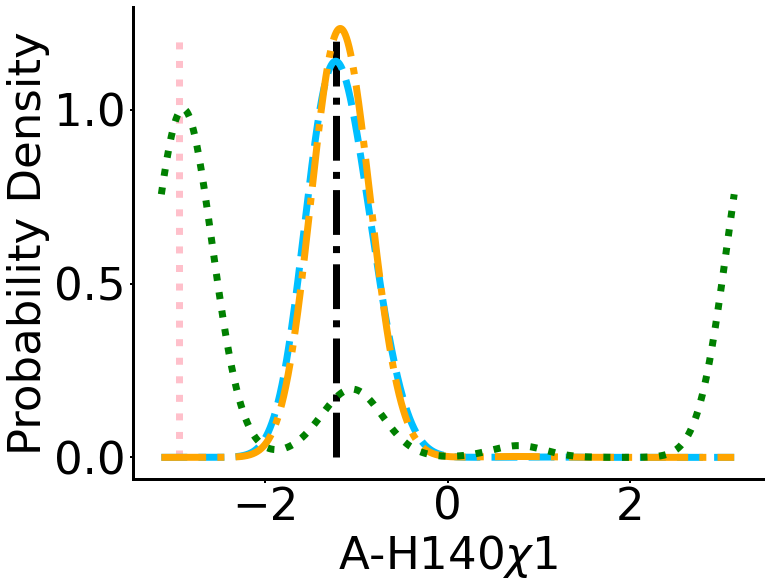

In [28]:
for i, vl in enumerate(selected):
    data = []
    path = 'Samples_2000'
    for st in states:
        if vl[0] > 306:
            dt = h5.File('Dihedral_2000/%s/protomer_B.h5' % st, 'r')
            data.append(np.array(dt[f'resid{vl[0]-306}']))
        elif vl[0] < 306:
            dt = h5.File('Dihedral_2000/%s/protomer_A.h5' % st, 'r')
            data.append(np.array(dt[f'resid{vl[0]}']))
    list_torsion = ['phi', 'psi', 'chi1', 'chi2']

    weight1 = weight_samples(group_clusters[n], population, cluster_indexes, path)
    weight2 = weight_samples(group_clusters[m], population, cluster_indexes, path)
    weight3 = weight_samples(group_clusters[k], population, cluster_indexes, path)
    jsd = JSD(data[n][l], data[m][l], weight1, weight2)
    print ('JSD:', jsd)
    a = KDE(data, n, m, k, weight1, weight2, weight3, vl[0], vl[1], distance=None)
    a.Ploting_dihedral(num_fr, path_to_f = p, cond = 'black', lw = 7.0, name_resid=list_name[i], ymax = 1.2,  
                       fgz=[4.25, 3.25], y_title ='Probability Density')